# Capstone Project
## Neural translation model
### Instructions

In this notebook, you will create a neural network that translates from English to German. You will use concepts from throughout this course, including building more flexible model architectures, freezing layers, data processing pipeline and sequence modelling.

This project is peer-assessed. Within this notebook you will find instructions in each section for how to complete the project. Pay close attention to the instructions as the peer review will be carried out according to a grading rubric that checks key parts of the project instructions.

### Let's get started!

We'll start by running some imports, and loading the dataset. For this project you are free to make further imports throughout the notebook as you wish. 

In [ ]:
import tensorflow as tf
import tensorflow_hub as hub
import unicodedata
import re
from IPython.display import Image

For the capstone project, you will use a language dataset from http://www.manythings.org/anki/ to build a neural translation model. This dataset consists of over 200,000 pairs of sentences in English and German. In order to make the training quicker, we will restrict to our dataset to 20,000 pairs. Feel free to change this if you wish - the size of the dataset used is not part of the grading rubric.

Your goal is to develop a neural translation model from English to German, making use of a pre-trained English word embedding module.

#### Import the data

The dataset is available for download as a zip file at the following link:

https://drive.google.com/open?id=1KczOciG7sYY7SB9UlBeRP1T9659b121Q

You should store the unzipped folder in Drive for use in this Colab notebook.

In [ ]:
# Run this cell to connect to your Drive folder

from google.colab import drive
drive.mount('/content/gdrive')

Mounted at /content/gdrive


In [ ]:
# Run this cell to load the dataset

NUM_EXAMPLES = 20000
data_examples = []
with open('/content/gdrive/MyDrive/Eng to ger/deu.txt', 'r', encoding='utf8') as f:
    for line in f.readlines():
        if len(data_examples) < NUM_EXAMPLES:
            data_examples.append(line)
        else:
            break

In [ ]:
# These functions preprocess English and German sentences

def unicode_to_ascii(s):
    return ''.join(c for c in unicodedata.normalize('NFD', s) if unicodedata.category(c) != 'Mn')

def preprocess_sentence(sentence):
    sentence = sentence.lower().strip()
    sentence = re.sub(r"ü", 'ue', sentence)
    sentence = re.sub(r"ä", 'ae', sentence)
    sentence = re.sub(r"ö", 'oe', sentence)
    sentence = re.sub(r'ß', 'ss', sentence)
    
    sentence = unicode_to_ascii(sentence)
    sentence = re.sub(r"([?.!,])", r" \1 ", sentence)
    sentence = re.sub(r"[^a-z?.!,']+", " ", sentence)
    sentence = re.sub(r'[" "]+', " ", sentence)
    
    return sentence.strip()

#### The custom translation model
The following is a schematic of the custom translation model architecture you will develop in this project.

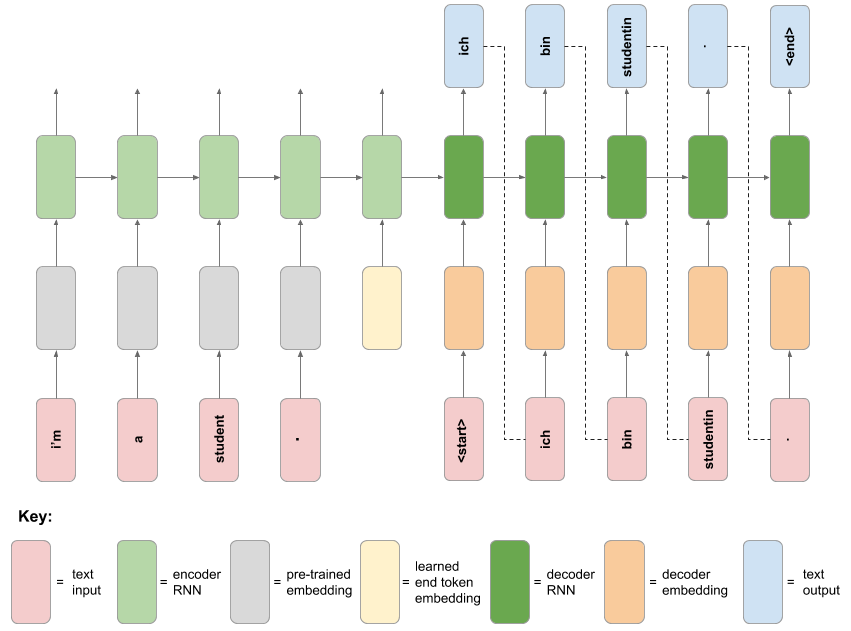

In [ ]:
# Run this cell to download and view a schematic diagram for the neural translation model

!wget -q -O neural_translation_model.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1XsS1VlXoaEo-RbYNilJ9jcscNZvsSPmd"
Image("neural_translation_model.png")

The custom model consists of an encoder RNN and a decoder RNN. The encoder takes words of an English sentence as input, and uses a pre-trained word embedding to embed the words into a 128-dimensional space. To indicate the end of the input sentence, a special end token (in the same 128-dimensional space) is passed in as an input. This token is a TensorFlow Variable that is learned in the training phase (unlike the pre-trained word embedding, which is frozen).

The decoder RNN takes the internal state of the encoder network as its initial state. A start token is passed in as the first input, which is embedded using a learned German word embedding. The decoder RNN then makes a prediction for the next German word, which during inference is then passed in as the following input, and this process is repeated until the special `<end>` token is emitted from the decoder.

## 1. Text preprocessing
* Create separate lists of English and German sentences, and preprocess them using the `preprocess_sentence` function provided for you above.
* Add a special `"<start>"` and `"<end>"` token to the beginning and end of every German sentence.
* Use the Tokenizer class from the `tf.keras.preprocessing.text` module to tokenize the German sentences, ensuring that no character filters are applied. _Hint: use the Tokenizer's "filter" keyword argument._
* Print out at least 5 randomly chosen examples of (preprocessed) English and German sentence pairs. For the German sentence, print out the text (with start and end tokens) as well as the tokenized sequence.
* Pad the end of the tokenized German sequences with zeros, and batch the complete set of sequences into one numpy array.

In [ ]:
data_examples

['Hi.\tHallo!\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #380701 (cburgmer)\n',
 'Hi.\tGrüß Gott!\tCC-BY 2.0 (France) Attribution: tatoeba.org #538123 (CM) & #659813 (Esperantostern)\n',
 'Run!\tLauf!\tCC-BY 2.0 (France) Attribution: tatoeba.org #906328 (papabear) & #941078 (Fingerhut)\n',
 'Wow!\tPotzdonner!\tCC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #2122382 (Pfirsichbaeumchen)\n',
 'Wow!\tDonnerwetter!\tCC-BY 2.0 (France) Attribution: tatoeba.org #52027 (Zifre) & #2122391 (Pfirsichbaeumchen)\n',
 'Fire!\tFeuer!\tCC-BY 2.0 (France) Attribution: tatoeba.org #1829639 (Spamster) & #1958697 (Tamy)\n',
 'Help!\tHilfe!\tCC-BY 2.0 (France) Attribution: tatoeba.org #435084 (lukaszpp) & #575889 (MUIRIEL)\n',
 'Help!\tZu Hülf!\tCC-BY 2.0 (France) Attribution: tatoeba.org #435084 (lukaszpp) & #2122375 (Pfirsichbaeumchen)\n',
 'Stop!\tStopp!\tCC-BY 2.0 (France) Attribution: tatoeba.org #448320 (FeuDRenais) & #626467 (jakov)\n',
 'Wait!\tWarte!\tCC-BY 2.0 (Fran

## How the Data Looks

English + TAB + German + TAB + Attribution 

In [ ]:
# splitting the sentences and then removing attributions and preprcessing them

def get_sentence(data_examples):
    eng_sentences = []
    german_sentences = []
    for data in data_examples:
        english, german = data.split('\t')[: -1] # ignoring the last attribution sentence
        
        english = preprocess_sentence(english)
        german = preprocess_sentence(german) # preprocessing with the above function
        
        # we need to add special tokens <start> and <end> in each german sentence
        german = '<start>' + ' ' + german + ' ' + '<end>'
        
      
        
        eng_sentences.append(english)
        german_sentences.append(german)
        
    return eng_sentences, german_sentences

In [ ]:
eng_sentences, german_sentences = get_sentence(data_examples)

german_sentences

['<start> hallo ! <end>',
 '<start> gruess gott ! <end>',
 '<start> lauf ! <end>',
 '<start> potzdonner ! <end>',
 '<start> donnerwetter ! <end>',
 '<start> feuer ! <end>',
 '<start> hilfe ! <end>',
 '<start> zu huelf ! <end>',
 '<start> stopp ! <end>',
 '<start> warte ! <end>',
 '<start> mach weiter . <end>',
 '<start> hallo ! <end>',
 '<start> ich rannte . <end>',
 '<start> ich verstehe . <end>',
 '<start> aha . <end>',
 '<start> ich probiere es . <end>',
 '<start> ich hab gewonnen ! <end>',
 '<start> ich habe gewonnen ! <end>',
 '<start> laecheln ! <end>',
 '<start> zum wohl ! <end>',
 '<start> iss auf . <end>',
 '<start> keine bewegung ! <end>',
 '<start> stehenbleiben ! <end>',
 '<start> kapiert ? <end>',
 '<start> verstanden ? <end>',
 '<start> einverstanden ? <end>',
 '<start> er rannte . <end>',
 '<start> er lief . <end>',
 '<start> mach mit ! <end>',
 '<start> drueck mich ! <end>',
 '<start> nimm mich in den arm ! <end>',
 '<start> umarme mich ! <end>',
 '<start> ich fiel . <e

In [ ]:
# fitting the tokenizer into german sentences

tokenizer = tf.keras.preprocessing.text.Tokenizer(filters = '')

tokenizer.fit_on_texts(german_sentences)

In [ ]:
tokenizer_config = tokenizer.get_config()
tokenizer_config.keys()

dict_keys(['num_words', 'filters', 'lower', 'split', 'char_level', 'oov_token', 'document_count', 'word_counts', 'word_docs', 'index_docs', 'index_word', 'word_index'])

#### Now lets see the word_counts of our tokenizer

In [ ]:
tokenizer_config['word_counts']

'{"<start>": 20000, "hallo": 19, "!": 1975, "<end>": 20000, "gruess": 1, "gott": 11, "lauf": 7, "potzdonner": 1, "donnerwetter": 1, "feuer": 6, "hilfe": 28, "zu": 664, "huelf": 1, "stopp": 2, "warte": 24, "mach": 124, "weiter": 74, ".": 15440, "ich": 4882, "rannte": 22, "verstehe": 24, "aha": 1, "probiere": 5, "es": 1841, "hab": 28, "gewonnen": 36, "habe": 820, "laecheln": 8, "zum": 42, "wohl": 17, "iss": 10, "auf": 407, "keine": 86, "bewegung": 2, "stehenbleiben": 1, "kapiert": 2, "?": 2602, "verstanden": 10, "einverstanden": 16, "er": 1032, "lief": 11, "mit": 191, "drueck": 5, "mich": 635, "nimm": 55, "in": 244, "den": 200, "arm": 27, "umarme": 2, "fiel": 11, "hin": 40, "stuerzte": 3, "bin": 1013, "hingefallen": 1, "gestuerzt": 1, "weiss": 115, "gelogen": 15, "verloren": 64, "bezahlt": 17, "zahlte": 2, "sang": 8, "schwimme": 6, "jahre": 14, "alt": 48, "mir": 651, "geht\'s": 17, "gut": 235, "geht": 162, "wach": 22, "unmoeglich": 4, "das": 1763, "kommt": 77, "nicht": 1552, "frage": 14,

### The above is the number of times each word appears in the corpus. As you can see, the word counts dictionaries in the config are serialized into plain JSON. The loads() method in the Python library json can be used to convert this JSON string into a dictionary.

In [ ]:
import json

word_counts = json.loads(tokenizer_config['word_counts'])

### Now lets also load word_index and index_word to convert our sentences from words to indices and indices to word respectively

In [ ]:
word_index = json.loads(tokenizer_config['word_index'])
index_word = json.loads(tokenizer_config['index_word'])

In [ ]:
# Now we are ready to tokenize our german sntences into list of sequences

german_sequence = tokenizer.texts_to_sequences(german_sentences)

import numpy as np
indices = np.random.randint(0, len(german_sentences), 5)

for index in indices:
    print(eng_sentences[index])
    print(german_sentences[index])
    print(german_sequence[index])
    print('')

may we swim here ?
<start> duerfen wir hier schwimmen ? <end>
[1, 911, 17, 33, 242, 7, 2]

tom is popular .
<start> tom ist beliebt . <end>
[1, 5, 6, 831, 3, 2]

i'll call tom .
<start> ich rufe tom an . <end>
[1, 4, 667, 5, 36, 3, 2]

things change .
<start> die dinge aendern sich . <end>
[1, 26, 1025, 775, 34, 3, 2]

i made supper .
<start> ich habe das abendbrot zubereitet . <end>
[1, 4, 18, 11, 1595, 2559, 3, 2]



#### Now we can see each sentences are of different length, so now lets pad the sentences

In [ ]:
german_sequence_padded = tf.keras.preprocessing.sequence.pad_sequences(german_sequence)
german_sequence_padded = np.array(german_sequence_padded)

In [ ]:
german_sequence_padded

array([[  0,   0,   0, ..., 405,   9,   2],
       [  0,   0,   0, ..., 663,   9,   2],
       [  0,   0,   0, ..., 975,   9,   2],
       ...,
       [  0,   0,   0, ..., 276,   3,   2],
       [  0,   0,   0, ..., 182,   3,   2],
       [  0,   0,   0, ..., 217,   3,   2]], dtype=int32)

In [ ]:
len(german_sequence_padded[3])

14

## 2. Prepare the data

#### Load the embedding layer
As part of the dataset preproceessing for this project, you will use a pre-trained English word embedding module from TensorFlow Hub. The URL for the module is https://tfhub.dev/google/tf2-preview/nnlm-en-dim128-with-normalization/1.

This embedding takes a batch of text tokens in a 1-D tensor of strings as input. It then embeds the separate tokens into a 128-dimensional space. 

The code to load and test the embedding layer is provided for you below.

**NB:** this model can also be used as a sentence embedding module. The module will process each token by removing punctuation and splitting on spaces. It then averages the word embeddings over a sentence to give a single embedding vector. However, we will use it only as a word embedding module, and will pass each word in the input sentence as a separate token.

In [ ]:
# Load embedding module from Tensorflow Hub

embedding_layer = hub.KerasLayer("https://tfhub.dev/google/tf2-preview/nnlm-en-dim128/1", 
                                 output_shape=[128], input_shape=[], dtype=tf.string)

In [ ]:
# Test the layer

embedding_layer(tf.constant(["these", "aren't", "the", "droids", "you're", "looking", "for"])).shape

TensorShape([7, 128])

You should now prepare the training and validation Datasets.

* Create a random training and validation set split of the data, reserving e.g. 20% of the data for validation (NB: each English dataset example is a single sentence string, and each German dataset example is a sequence of padded integer tokens).
* Load the training and validation sets into a tf.data.Dataset object, passing in a tuple of English and German data for both training and validation sets.
* Create a function to map over the datasets that splits each English sentence at spaces. Apply this function to both Dataset objects using the map method. _Hint: look at the tf.strings.split function._
* Create a function to map over the datasets that embeds each sequence of English words using the loaded embedding layer/model. Apply this function to both Dataset objects using the map method.
* Create a function to filter out dataset examples where the English sentence is greater than or equal to than 13 (embedded) tokens in length. Apply this function to both Dataset objects using the filter method.
* Create a function to map over the datasets that pads each English sequence of embeddings with some distinct padding value before the sequence, so that each sequence is length 13. Apply this function to both Dataset objects using the map method. _Hint: look at the tf.pad function. You can extract a Tensor shape using tf.shape; you might also find the tf.math.maximum function useful._
* Batch both training and validation Datasets with a batch size of 16.
* Print the `element_spec` property for the training and validation Datasets. 
* Using the Dataset `.take(1)` method, print the shape of the English data example from the training Dataset.
* Using the Dataset `.take(1)` method, print the German data example Tensor from the validation Dataset.

In [ ]:
from sklearn.model_selection import train_test_split

eng_train, eng_test, german_train, german_test = train_test_split(eng_sentences, german_sequence_padded, test_size = 0.2)

In [ ]:
train_dataset = tf.data.Dataset.from_tensor_slices((eng_train, german_train))
val_dataset = tf.data.Dataset.from_tensor_slices((eng_test, german_test))

In [ ]:
# Mapping the input english sentence into word tokens

def map_func(eng_sentence, ger_seq):
    return tf.strings.split(eng_sentence, sep = None), ger_seq

train_dataset = train_dataset.map(map_func)
val_dataset = val_dataset.map(map_func)

In [ ]:
train_dataset.element_spec

(TensorSpec(shape=(None,), dtype=tf.string, name=None),
 TensorSpec(shape=(14,), dtype=tf.int32, name=None))

### mapping tokens to embedding

In [ ]:
def map_func_emb(eng_tokens, ger_seq):

        return embedding_layer(eng_tokens), ger_seq

In [ ]:
train_dataset = train_dataset.map(map_func_emb)
val_dataset = val_dataset.map(map_func_emb)

In [ ]:
train_dataset.element_spec

(TensorSpec(shape=(None, 128), dtype=tf.float32, name=None),
 TensorSpec(shape=(14,), dtype=tf.int32, name=None))

In [ ]:
# Filtering out sentences having more than 13 token embeddings

train_dataset = train_dataset.filter(lambda x, y: tf.shape(x)[0] <= 13)
val_dataset = val_dataset.filter(lambda x, y: tf.shape(x)[0] <= 13)


In [ ]:
def map_pad_func(x, y):
    num_emb = tf.shape(x)[0] #number of tokens embedded
    
    # We need 13, 128 dimension vetcors so
    x = tf.pad(x, paddings=[[13-num_emb, 0], [0, 0]])
    return x, y

In [ ]:
train_dataset = train_dataset.map(map_pad_func)
val_dataset = val_dataset.map(map_pad_func)


In [ ]:
train_dataset = train_dataset.batch(16)
val_dataset = val_dataset.batch(16)

In [ ]:
print(train_dataset.element_spec)
print(val_dataset.element_spec)

(TensorSpec(shape=(None, None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.int32, name=None))
(TensorSpec(shape=(None, None, 128), dtype=tf.float32, name=None), TensorSpec(shape=(None, 14), dtype=tf.int32, name=None))


In [ ]:
#printing english token vectors in train dataset

x = train_dataset.take(1)
list(x)[0][0]


<tf.Tensor: shape=(16, 13, 128), dtype=float32, numpy=
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.03886752,  0.0589633 , -0.05857971, ..., -0.01113926,
          0.11953395, -0.18164876],
        [-0.01622026, -0.04812252, -0.04774033, ..., -0.09642013,
         -0.02895776, -0.05712311],
        [-0.01335301,  0.11507112,  0.12568313, ...,  0.08157409,
          0.13599715, -0.03076603]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,

## 3. Create the custom layer
You will now create a custom layer to add the learned end token embedding to the encoder model:

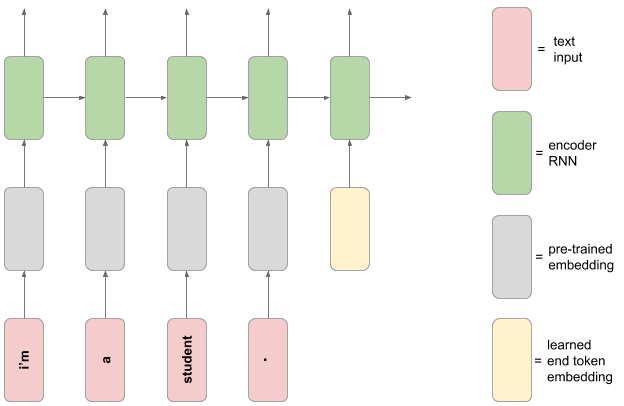

In [ ]:
# Run this cell to download and view a schematic diagram for the encoder model

!wget -q -O neural_translation_model.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1JrtNOzUJDaOWrK4C-xv-4wUuZaI12sQI"
Image("neural_translation_model.png")

You should now build the custom layer.
* Using layer subclassing, create a custom layer that takes a batch of English data examples from one of the Datasets, and adds a learned embedded ‘end’ token to the end of each sequence. 
* This layer should create a TensorFlow Variable (that will be learned during training) that is 128-dimensional (the size of the embedding space). _Hint: you may find it helpful in the call method to use the tf.tile function to replicate the end token embedding across every element in the batch._
* Using the Dataset `.take(1)` method, extract a batch of English data examples from the training Dataset and print the shape. Test the custom layer by calling the layer on the English data batch Tensor and print the resulting Tensor shape (the layer should increase the sequence length by one).

In [ ]:
from tensorflow.keras.layers import Layer

class custom_layer(Layer):
    def __init__(self, **kwargs):
        super(custom_layer, self).__init__(**kwargs)
        self.end_token = self.add_weight(shape = (1, 128), initializer = 'random_normal')
    
    def call(self, inputs):
        end_token_seq = tf.expand_dims(tf.tile(self.end_token, [tf.shape(inputs)[0], 1]), axis = 1)
        return tf.concat([inputs, end_token_seq], axis = 1)

In [ ]:
random_dataset = train_dataset.take(1)

In [ ]:
eng_emb = list(random_dataset)[0][0]
my_layer = custom_layer()
x = my_layer(eng_emb)
x 

<tf.Tensor: shape=(16, 14, 128), dtype=float32, numpy=
array([[[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,
        [-0.01622026, -0.04812252, -0.04774033, ..., -0.09642013,
         -0.02895776, -0.05712311],
        [-0.01335301,  0.11507112,  0.12568313, ...,  0.08157409,
          0.13599715, -0.03076603],
        [-0.03580181,  0.03643415, -0.10489489, ...,  0.02797154,
          0.0298958 ,  0.00245495]],

       [[ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        [ 0.        ,  0.        ,  0.        , ...,  0.        ,
          0.        ,  0.        ],
        ...,

### We can see shape of batch's sequence increases from 13 to 14 which was expected

## 4. Build the encoder network
The encoder network follows the schematic diagram above. You should now build the RNN encoder model.
* Using the functional API, build the encoder network according to the following spec:
    * The model will take a batch of sequences of embedded English words as input, as given by the Dataset objects.
    * The next layer in the encoder will be the custom layer you created previously, to add a learned end token embedding to the end of the English sequence.
    * This is followed by a Masking layer, with the `mask_value` set to the distinct padding value you used when you padded the English sequences with the Dataset preprocessing above.
    * The final layer is an LSTM layer with 512 units, which also returns the hidden and cell states.
    * The encoder is a multi-output model. There should be two output Tensors of this model: the hidden state and cell states of the LSTM layer. The output of the LSTM layer is unused.
* Using the Dataset `.take(1)` method, extract a batch of English data examples from the training Dataset and test the encoder model by calling it on the English data Tensor, and print the shape of the resulting Tensor outputs.
* Print the model summary for the encoder network.

In [ ]:
from tensorflow.keras.layers import Input, LSTM, Masking, Dense
from tensorflow.keras.models import Model


def get_encoder_model(input_shape = (None, 128)):
    
    inputs = Input(shape = input_shape)
    x = custom_layer()(inputs)
    x = Masking()(x)
    lstm_output, hidden_state, cell_state = LSTM(512, return_state = True)(x)
    
    model = Model(inputs, [hidden_state, cell_state])
    
    return model

In [ ]:
# we will use our previous eng_emb input tensor
encoder_model = get_encoder_model()
random_dataset = list(train_dataset.take(1))
x = random_dataset[0][0]
tensor_out = encoder_model(x)
for tensor in tensor_out:
    print(tf.shape(tensor)) #shape of tensors

tf.Tensor([ 16 512], shape=(2,), dtype=int32)
tf.Tensor([ 16 512], shape=(2,), dtype=int32)


In [ ]:
encoder_model.summary()

Model: "model"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         [(None, None, 128)]       0         
_________________________________________________________________
custom_layer_1 (custom_layer (None, None, 128)         128       
_________________________________________________________________
masking (Masking)            (None, None, 128)         0         
_________________________________________________________________
lstm (LSTM)                  [(None, 512), (None, 512) 1312768   
Total params: 1,312,896
Trainable params: 1,312,896
Non-trainable params: 0
_________________________________________________________________


## 5. Build the decoder network
The decoder network follows the schematic diagram below. 

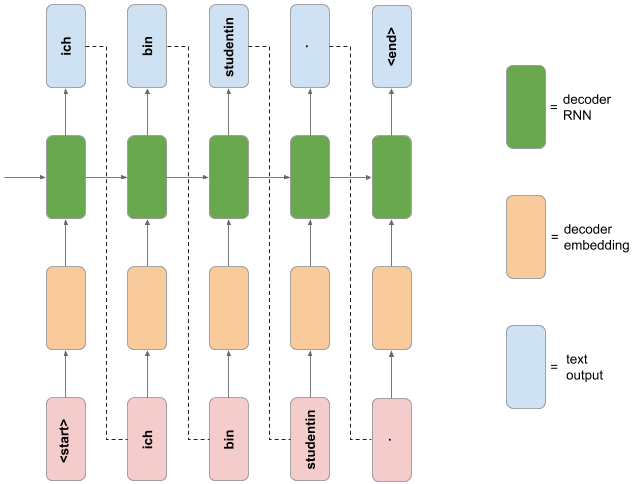

In [ ]:
# Run this cell to download and view a schematic diagram for the decoder model

!wget -q -O neural_translation_model.png --no-check-certificate "https://docs.google.com/uc?export=download&id=1DTeaXD8tA8RjkpVrB2mr9csSBOY4LQiW"
Image("neural_translation_model.png")

You should now build the RNN decoder model.
* Using Model subclassing, build the decoder network according to the following spec:
    * The initializer should create the following layers:
        * An Embedding layer with vocabulary size set to the number of unique German tokens, embedding dimension 128, and set to mask zero values in the input.
        * An LSTM layer with 512 units, that returns its hidden and cell states, and also returns sequences.
        * A Dense layer with number of units equal to the number of unique German tokens, and no activation function.
    * The call method should include the usual `inputs` argument, as well as the additional keyword arguments `hidden_state` and `cell_state`. The default value for these keyword arguments should be `None`.
    * The call method should pass the inputs through the Embedding layer, and then through the LSTM layer. If the `hidden_state` and `cell_state` arguments are provided, these should be used for the initial state of the LSTM layer. _Hint: use the_ `initial_state` _keyword argument when calling the LSTM layer on its input._
    * The call method should pass the LSTM output sequence through the Dense layer, and return the resulting Tensor, along with the hidden and cell states of the LSTM layer.
* Using the Dataset `.take(1)` method, extract a batch of English and German data examples from the training Dataset. Test the decoder model by first calling the encoder model on the English data Tensor to get the hidden and cell states, and then call the decoder model on the German data Tensor and hidden and cell states, and print the shape of the resulting decoder Tensor outputs.
* Print the model summary for the decoder network.

In [ ]:
unique_german_tokens = len(word_index)+1
print(unique_german_tokens)

embedding_dimension = 128

5744


In [ ]:
class get_decoder_model(Model):
    
    def __init__(self, unique_german_tokens = 5744, **kwargs):
        super(get_decoder_model, self).__init__(**kwargs)
        self.unique_german_tokens = unique_german_tokens
        self.embedding = tf.keras.layers.Embedding(unique_german_tokens, output_dim = 128, mask_zero=True)
        self.lstm = LSTM(512, return_sequences=True, return_state=True)
        self.dense = Dense(unique_german_tokens, activation=None)
        
    def call(self, inputs, hidden_state = None, cell_state = None):
            x = self.embedding(inputs)
            lstm, hidden_state_out, cell_state_out = self.lstm(x, initial_state=[hidden_state, cell_state])
            x = self.dense(lstm)
            
            return [x, hidden_state_out, cell_state_out]
            

### Now lets pass a random dataset to our encoder and decoder models and see the expected shapes

In [ ]:
random_dataset = list(train_dataset.take(1))
eng = random_dataset[0][0]
ger = random_dataset[0][1]

encoder = get_encoder_model( )#passing input shape as expected
hidden_state, cell_state = encoder(eng)

decoder = get_decoder_model(unique_german_tokens) # passing unique_german_tokens for input_dim of emnedding layer

dense_out, hidden_state_out, cell_state_out = decoder(ger, hidden_state, cell_state)

print(tf.shape(dense_out))
print(tf.shape(hidden_state_out))
print(tf.shape(cell_state_out))

tf.Tensor([  16   14 5744], shape=(3,), dtype=int32)
tf.Tensor([ 16 512], shape=(2,), dtype=int32)
tf.Tensor([ 16 512], shape=(2,), dtype=int32)


### Before making a custom traning loop what we can do is combine both encoder and decoder model into one model so that we it will be easy to handle

In [ ]:
def get_model(input_shape_eng = (None, 128), input_shape_ger = (None, )):
    enc = get_encoder_model()
    dec = get_decoder_model()
    input_eng = Input(input_shape_eng)
    input_ger = Input(input_shape_ger)
    h, c = enc(input_eng)
    x, h_o, c_o = dec(input_ger, h, c)
    
    model = Model(inputs = [input_eng, input_ger], outputs = [x, h_o, c_o]) # this model outputs dense output along with decoder hidden and cell states
    
    return model, enc, dec

In [ ]:

model, _, _ = get_model()
model.summary()

Model: "model_3"
__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_4 (InputLayer)            [(None, None, 128)]  0                                            
__________________________________________________________________________________________________
input_5 (InputLayer)            [(None, None)]       0                                            
__________________________________________________________________________________________________
model_2 (Functional)            [(None, 512), (None, 1312896     input_4[0][0]                    
__________________________________________________________________________________________________
get_decoder_model_1 (get_decode [(None, None, 5744), 4994672     input_5[0][0]                    
                                                                 model_2[0][0]              

## 6. Make a custom training loop
You should now write a custom training loop to train your custom neural translation model.
* Define a function that takes a Tensor batch of German data (as extracted from the training Dataset), and returns a tuple containing German inputs and outputs for the decoder model (refer to schematic diagram above).
* Define a function that computes the forward and backward pass for your translation model. This function should take an English input, German input and German output as arguments, and should do the following:
    * Pass the English input into the encoder, to get the hidden and cell states of the encoder LSTM.
    * These hidden and cell states are then passed into the decoder, along with the German inputs, which returns a sequence of outputs (the hidden and cell state outputs of the decoder LSTM are unused in this function).
    * The loss should then be computed between the decoder outputs and the German output function argument.
    * The function returns the loss and gradients with respect to the encoder and decoder’s trainable variables.
    * Decorate the function with `@tf.function`
* Define and run a custom training loop for a number of epochs (for you to choose) that does the following:
    * Iterates through the training dataset, and creates decoder inputs and outputs from the German sequences.
    * Updates the parameters of the translation model using the gradients of the function above and an optimizer object.
    * Every epoch, compute the validation loss on a number of batches from the validation and save the epoch training and validation losses.
* Plot the learning curves for loss vs epoch for both training and validation sets.

_Hint: This model is computationally demanding to train. The quality of the model or length of training is not a factor in the grading rubric. However, to obtain a better model we recommend using the GPU accelerator hardware on Colab._

In [ ]:
def get_german_data(inputs):
    german_input = inputs[:, :-1] # excluding the last german token
    german_output = inputs[:, 1:] # excluding the first token
    
    return (german_input, german_output)

In [ ]:
@tf.function
def get_loss_and_grads(eng, ger_in, ger_out, model, loss):  
    with tf.GradientTape() as tape:

        ger_out_hat,_,_ = model([eng, ger_in])
        tape.watch(model.trainable_variables)
        loss_value = loss(ger_out, ger_out_hat)
         
    return ger_out_hat, loss_value, tape.gradient(loss_value, model.trainable_variables)

In [ ]:
# Create lists to accumulate the metric values

train_loss_results = []
train_categorical_accuracy_results = []

val_loss_results = []
val_categorical_accuracy_results = []

In [ ]:
# custom training loop
import time
from tensorflow.keras.utils import to_categorical

num_epochs = 20
val_steps = 10
optimizer = tf.keras.optimizers.Adam(learning_rate=0.005)
loss = tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True)
model, encoder, decoder = get_model()

for epoch in range(num_epochs):
    start_time = time.time()

    train_epoch_loss_avg = tf.keras.metrics.Mean()
    train_epoch_categorical_accuracy = tf.keras.metrics.CategoricalAccuracy()
    
    val_epoch_loss_avg = tf.keras.metrics.Mean()
    val_epoch_categorical_accuracy = tf.keras.metrics.CategoricalAccuracy()

    for eng, ger in train_dataset:
        ger_in, ger_out = get_german_data(ger) # getting german data by our custom function
        
        model_preds, loss_value, grad = get_loss_and_grads(eng, ger_in, ger_out, model, loss)
        
        optimizer.apply_gradients(zip(grad, model.trainable_variables))
       
        train_epoch_loss_avg(loss_value)
        train_epoch_categorical_accuracy(to_categorical(ger_out, num_classes = 5744), model_preds)
        
    for eng, ger in val_dataset.take(val_steps):
        ger_in, ger_out = get_german_data(ger)
        
        model_preds,_,_ = model([eng, ger_in])
        val_epoch_loss_avg(loss(ger_out, model_preds))
        val_epoch_categorical_accuracy(to_categorical(ger_out,  num_classes = 5744), model_preds)
        
        
    train_loss_results.append(train_epoch_loss_avg.result().numpy())
    train_categorical_accuracy_results.append(train_epoch_categorical_accuracy.result().numpy())
    
    val_loss_results.append(val_epoch_loss_avg.result().numpy())
    val_categorical_accuracy_results.append(val_epoch_categorical_accuracy.result().numpy())

    end_time = time.time()
    
    print("Epoch {:02d}: | Time :{:.2f} secs  Training loss: {:.3f}, train categorical acc: {:.3%}".format(epoch+1, end_time-start_time,train_epoch_loss_avg.result(), 
                                                                        train_epoch_categorical_accuracy.result().numpy()))
    print("              Validation loss: {:.3f}, Val categorical acc {:.3%}".format(val_epoch_loss_avg.result(),
                                                                         val_epoch_categorical_accuracy.result().numpy()))

Epoch 01: | Time :102.12 secs  Training loss: 4.232, train categorical acc: 54.289%
              Validation loss: 2.238, Val categorical acc 72.740%
Epoch 02: | Time :99.51 secs  Training loss: 1.512, train categorical acc: 74.576%
              Validation loss: 1.348, Val categorical acc 75.529%
Epoch 03: | Time :99.27 secs  Training loss: 1.022, train categorical acc: 76.933%
              Validation loss: 1.262, Val categorical acc 76.058%
Epoch 04: | Time :99.67 secs  Training loss: 0.824, train categorical acc: 79.081%
              Validation loss: 1.268, Val categorical acc 76.106%
Epoch 05: | Time :99.21 secs  Training loss: 0.694, train categorical acc: 80.987%
              Validation loss: 1.279, Val categorical acc 76.779%
Epoch 06: | Time :99.08 secs  Training loss: 0.600, train categorical acc: 82.630%
              Validation loss: 1.264, Val categorical acc 77.067%
Epoch 07: | Time :99.20 secs  Training loss: 0.533, train categorical acc: 84.031%
              Validati

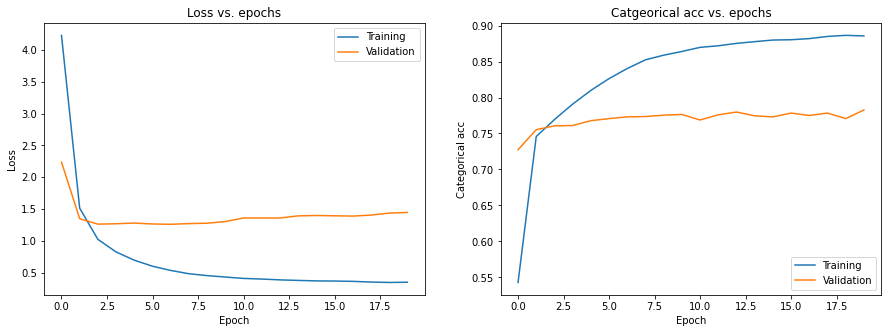

In [ ]:
#plotting the graphs
import matplotlib.pyplot as plt

fig = plt.figure(figsize=(15, 5))

fig.add_subplot(121)
plt.plot(train_loss_results)
plt.plot(val_loss_results)
plt.title('Loss vs. epochs')
plt.ylabel('Loss')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='upper right')

fig.add_subplot(122)
plt.plot(train_categorical_accuracy_results)
plt.plot(val_categorical_accuracy_results)
plt.title('Catgeorical acc vs. epochs')
plt.ylabel('Categorical acc')
plt.xlabel('Epoch')
plt.legend(['Training', 'Validation'], loc='lower right')
plt.show() 

## 7. Use the model to translate
Now it's time to put your model into practice! You should run your translation for five randomly sampled English sentences from the dataset. For each sentence, the process is as follows:
* Preprocess and embed the English sentence according to the model requirements.
* Pass the embedded sentence through the encoder to get the encoder hidden and cell states.
* Starting with the special  `"<start>"` token, use this token and the final encoder hidden and cell states to get the one-step prediction from the decoder, as well as the decoder’s updated hidden and cell states.
* Create a loop to get the next step prediction and updated hidden and cell states from the decoder, using the most recent hidden and cell states. Terminate the loop when the `"<end>"` token is emitted, or when the sentence has reached a maximum length.
* Decode the output token sequence into German text and print the English text and the model's German translation.

### first lets randomly sample out 5 sentences from data_examples and then preprocess it

In [ ]:
indices  = np.random.randint(0, len(data_examples), size = 5)

test_examples = [data_examples[index] for index in indices]


TypeError: ignored

In [ ]:
eng_test, ger_test = get_sentence(test_examples) # prepocessing using our custom function

In [ ]:
eng_test

['what woke you up ?',
 'please let me in .',
 'tom is wealthy .',
 'will you help us ?',
 'the fire is out .']

In [ ]:
test_dataset = tf.data.Dataset.from_tensor_slices((eng_test, ger_test))

In [ ]:
test_dataset = test_dataset.map(map_func)
test_dataset = test_dataset.map(map_func_emb)

In [ ]:
test_dataset.element_spec

(TensorSpec(shape=(None, 128), dtype=tf.float32, name=None),
 TensorSpec(shape=(), dtype=tf.string, name=None))

In [ ]:
eng_emb_test = list(test_dataset)


In [ ]:
for eng_sen in eng_test:
  print(eng_sen)   # printing english sentences to compare

print()
print('GERMAN TRANSLATION')
print()

for eng_emb, _ in eng_emb_test: # getting sentences embedding one by one

  h, c = encoder(tf.expand_dims(eng_emb, axis = 0)) # encoder model expects a batch hence expanding dimension

  x, h_o, c_o = decoder(np.array(tokenizer.texts_to_sequences(['<start>'])), h, c) # passing the <start> token

  index_out = tf.math.argmax(x[0], axis = 1) # finding index having max probability
  
  word = index_word[str(index_out.numpy()[0])] # converting index into word by help of index_word dict
  print(word, end = ' ')

  len = 1
  max_len = 14 # setting max_len = 14

  while len < max_len: # sentences excedding length 14 will break out from loop

    x, h_o, c_o = decoder(np.array(tokenizer.texts_to_sequences([word])), h_o, c_o) #updating hidden and cell states

    index_out = tf.math.argmax(x[0], axis = 1)

    word = index_word[str(index_out.numpy()[0])]

    if word == '<end>':
      break
    print(word, end = ' ')
    
    len+=1
  print()

what woke you up ?
please let me in .
tom is wealthy .
will you help us ?
the fire is out .

GERMAN TRANSLATION

was hat dich geweckt ? 
helfen sie mich , bitte . 
tom ist reich . 
hilfst du mit ? 
das feuer ging aus . 
